In [1]:
# To find ECD Control

import sys 
sys.path.append('C:\\Users\\Eesh Gupta\\Documents\\RU Research\\Chakram')


In [2]:
import numpy as np
from qutip import *
from DECD_paramV1 import FixedBatchOptimizer as BatchOptimizer
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#Modes Truncation
N1 = 10
N2 = 10

In [5]:
#The target oscillator state.
#Initial oscillator state.
Fock1 = 0
Fock2= 0
psi_i1 = basis(N1,Fock1) #initial state
psi_i2 = basis(N2,Fock2)
initial = tensor(basis(2,0), psi_i1, psi_i2)

#Target
Fock1 = 1
Fock2= 1
psi_t1 = basis(N1,Fock1) #target state
psi_t2 = basis(N2,Fock2)
target = tensor(basis(2, 0), psi_t1, psi_t2)

In [6]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
opt_params = {
    'N_blocks' : 2, #circuit depth
    'N_multistart' : 2, #Batch size (number of circuit optimizations to run in parallel)
    'epochs' : 200, #number of epochs before termination
    'epoch_size' : 20, #number of adam steps per epoch
    'learning_rate' : 0.01, #adam learning rate
    'term_fid' : 0.995, #terminal fidelitiy
    'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
    'beta_scale' : 3.0, #maximum |beta| for random initialization
    'gamma_scale' : 3.0, #maximum |gamma| for random initialization
    'N_cav1': N1, #number of levels in mode 1
    'N_cav2': N2, #number of levels in mode 2
    'initial_states' : [initial], #qubit tensor oscillator, start in |g> |0>
    'target_states' : [target], #end in |e> |target>.
    #"initial_params": init_params,
    #'name' : 'Fock1 %d' % Fock1, #name for printing and saving
    'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
    }


#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

#### Filename for angles to be stored

In [7]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(**opt_params)

#print optimization info. 
opt.print_info()

None
Fixed construct needed matrices called
optimization_type: state transfer
N_multistart: 2
N_blocks: 2
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 20
epochs: 200
beta_scale: 3.0
gamma_scale: 3.0
alpha1_scale: 1.0
alpha2_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: ECD_control
comment: 
initial_params: None
N_cav1: 10
N_cav2: 10
filename: ECD_control.h5

Best circuit parameters found:
betas:         [0.21002+0.59022j 0.21103+1.27514j]
gammas:         [0.20427-0.10548j 1.36854+1.81751j]
alphas1:        [0.+0.j]
alphas2:        [0.+0.j]
phis (deg):    [  0.      -43.35429]
etas (deg):    [89.99999 89.99999]
thetas (deg):  [-42.38978  58.93001]
Max Fidelity:  0.098884




In [8]:
#run optimizer.
#opt.optimize()

In [9]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 2
N_blocks: 2
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 20
epochs: 200
beta_scale: 3.0
gamma_scale: 3.0
alpha1_scale: 1.0
alpha2_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: ECD_control
comment: 
initial_params: None
N_cav1: 10
N_cav2: 10
filename: ECD_control.h5

Best circuit parameters found:
betas:         [0.21002+0.59022j 0.21103+1.27514j]
gammas:         [0.20427-0.10548j 1.36854+1.81751j]
alphas1:        [0.+0.j]
alphas2:        [0.+0.j]
phis (deg):    [  0.      -43.35429]
etas (deg):    [89.99999 89.99999]
thetas (deg):  [-42.38978  58.93001]
Max Fidelity:  0.098884




In [10]:
angles_filename = 'test_opt_angles.txt'
opt.save_angles(filename = angles_filename)

# Get Pulses

In [11]:
from Simulation_Classes_Two_ModeV2 import *
# Classes: ecd_pulse_single_mode to get pulses
#          , qutip_sim_single_mode to simulate on qutip

In [28]:
T1_mode1 = 2e+6 #2ms
T1_mode2 = 2e+6 #2ms

pulse_sim = ecd_pulse_two_mode(param_file = angles_filename,
                              kappa1 = 1/T1_mode1,
                              kappa2 = 1/T1_mode2)

In [29]:
pulse_sim.get_pulses()

---------------------------------------------------
final displacement is 0.6264704103127516


C:\Users\Eesh Gupta\anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


---------------------------------------------------
final displacement is 0.22989533032451037
---------------------------------------------------
final displacement is 1.293745366540007
---------------------------------------------------
final displacement is 2.2760892290889756


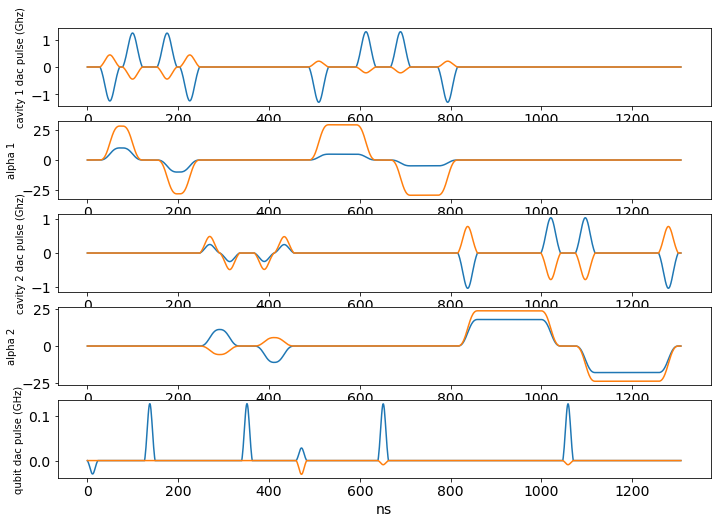

In [30]:
pulse_sim.plot_pulses()

# Qutip Simulation

In [31]:
qutip_sim  = qutip_sim_two_mode(n_q = 2, n_c1 = 10, n_c2 = 10, alpha1 = pulse_sim.alpha1, alpha2 = pulse_sim.alpha2, qubit_pulse = pulse_sim.qubit_dac_pulse_GHz)

In [32]:
# Add various terms 

# to the hamiltonian 
qutip_sim.add_bare_qubit_mode_coupling() # chi/2 adag a sigmaz
qutip_sim.add_mode_mode_coupling()
qutip_sim.add_stark_shift() # chi/2 alpha^2 sigmaz

# to the collapse operators (noise)
qutip_sim.add_qubit_relaxation(T1 = 30e+3) # T1 in nanoseconds
qutip_sim.add_qubit_dephasing(T1 = 30e+3, Techo = 50e+3) # T1, T2 in nanoseconds
qutip_sim.add_cavity_relaxation(T1_mode1 = 2e+6, T1_mode2 = 2e+6) # assumes kappa correction to equation of motion in pulses
qutip_sim.add_cavity_dephasing(T1_mode1 = 2e+6, Techo_mode1 = 3e+6, T1_mode2 = 2e+6, Techo_mode2 = 3e+6) # T1, T2 from photon blockade paper


In [33]:
qutip_sim.me_solve(initial = initial)  #initial state by default is g0

Loaded list object.


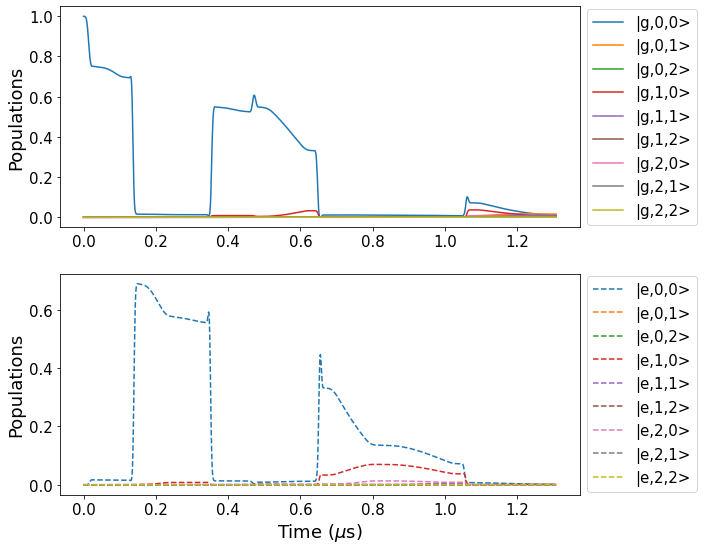

In [34]:
qutip_sim.plot_populations()

In [35]:
qutip_sim.get_fidelity(target)

0.008804368859147663